## ① データのアップデート

In [30]:
#ライブラリのインポート
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "AppleGothic"
import matplotlib as mpl
%matplotlib inline

#買取データの日付を取得する。
import datetime
from datetime import date, timedelta
today = datetime.date.today()
today = today.strftime('%y-%m-%d')

#表示の設定を行う。
pd.set_option('display.max_columns',8)
pd.set_option('display.max_rows',20)

In [2]:
#　requestsメソッドを使って、サイトからHTMLの情報を抽出する。
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTy1ZbSq5OAVbEqScDw_Uf_KfLKydg0uUWBaBEPK_DXaBPCHmwv4ru9MzZHHnVHVmRVvLvOlndJ2ZNZ/pubhtml?gid=159569114&amp;single=true&amp;widget=true&amp;headers=false&amp;gid=0&amp;range=A:F%22'
res = requests.get(url)

In [3]:
#　BeautifulSoup()の設定を行う。
soup = BeautifulSoup(res.text,'html.parser')

In [4]:
# 最新弾の情報を抽出する。
poke_new = soup.find('div',id ='1490875147')
# s3(カード名、型番）の要素を抽出する。
card_data = poke_new.find_all('td')

#情報をリストに格納する。
card_name = []
card_spec = []
card_rare = []
card_num = []
card_type = []
card_price = []

for i in range(0,349):
    card_name.append(card_data[6*i].string)
    card_spec.append(card_data[6*i+1].string)
    card_rare.append(card_data[6*i+2].string)
    card_num.append(card_data[6*i+3].string)
    card_type.append(card_data[6*i+4].string)
    card_price.append(card_data[6*i+5].string)
    
# データの結合を行う。
df_new = pd.concat([
    pd.DataFrame(card_name),
    pd.DataFrame(card_spec),
    pd.DataFrame(card_rare),
    pd.DataFrame(card_num),
    pd.DataFrame(card_type),
    pd.DataFrame(card_price)],axis = 1)
#0行目をカラムに設定する。
df_new.columns = df_new.iloc[0]
df_new = df_new.drop(0)

#価格が欠損値になっている行を削除する。
df_new = df_new.dropna(subset = ['買取'])

df_new.columns = ['カード名', '仕様', 'R', '型番', 'タイプ',today]

In [5]:
#### 通常の情報を抽出する。
poke_norm = soup.find('div',id ='159569114')
# s3(カード名、型番）の要素を抽出する。
card_data = poke_norm.find_all('td')

#情報をリストに格納する。
card_name = []
card_spec = []
card_rare = []
card_num = []
card_type = []
card_price = []

for i in range(0,3644):
    card_name.append(card_data[6*i].string)
    card_spec.append(card_data[6*i+1].string)
    card_rare.append(card_data[6*i+2].string)
    card_num.append(card_data[6*i+3].string)
    card_type.append(card_data[6*i+4].string)
    card_price.append(card_data[6*i+5].string)

# データの結合を行う。
df_norm = pd.concat([
    pd.DataFrame(card_name),
    pd.DataFrame(card_spec),
    pd.DataFrame(card_rare),
    pd.DataFrame(card_num),
    pd.DataFrame(card_type),
    pd.DataFrame(card_price)],axis = 1)
#0行目をカラムに設定する。
df_norm.columns = df_norm.iloc[0]
df_norm = df_norm.drop(0)

#価格が欠損値になっている行を削除する。
df_norm = df_norm.dropna(subset = ['買取価格'])

df_norm.columns = ['カード名', '仕様', 'R', '型番', 'タイプ',today]

In [6]:
#更新日のデータを完成させる。
#データを結合する。
df_today = pd.concat([df_norm,df_new],ignore_index = True)
df_today.columns = ['カード名', '仕様', 'R', '型番', 'タイプ',today]

In [7]:
#集計データを読み込む。
df_preday = pd.read_csv('cardrush_data.csv')

In [8]:
#結合のためのkeyを作る。(df_all)

df_today['key'] = df_today['カード名'].str.cat(df_today['型番'],sep = ' , ',na_rep='')
df_today['key'] = df_today['key'].str.cat(df_today['仕様'],sep = ' ,' ,na_rep='')
df_today['key'] = df_today['key'].str.cat(df_today['R'],sep = ' ,' ,na_rep='')

# print('df_todayのユニークなkeyの個数:',len(df_today['key'].unique()))
# print('df_todayのデータの列数:',len(df_today))
# print('df_todayのkeyに重複のあるデータ:\n',df_today[df_today['key'].duplicated()])

In [9]:
#結合のためのkeyを作る。(df_all)

df_preday['key'] = df_preday['カード名'].str.cat(df_preday['型番'],sep = ' , ',na_rep='')
df_preday['key'] = df_preday['key'].str.cat(df_preday['仕様'],sep = ' ,' ,na_rep='')
df_preday['key'] = df_preday['key'].str.cat(df_preday['R'],sep = ' ,' ,na_rep='')

# print('df_predayのユニークなkeyの個数:',len(df_preday['key'].unique()))
# print('df_predayのデータの列数:',len(df_preday))
# print('df_predayのkeyに重複のあるデータ:\n',df_preday[df_preday['key'].duplicated()])

In [10]:
#keyが被る行にtodayの数値を代入する。

df_preday[today] = 0
df_preday

for i in range(len(df_preday)):
    for j in range(len(df_today)):
        if df_preday.loc[i,'key'] == df_today.loc[j,'key']:
            df_preday.loc[i,today] = df_today.loc[j,today]
            break

In [11]:
count = 0
for i in range(len(df_today)):
    flg = 0
    for j in range(len(df_preday)):
        if df_today.loc[i,'key'] == df_preday.loc[j,'key']:
            flg = 1
            break
            
    if flg == 0:
        df_preday = pd.concat([df_preday,df_today[i:i+1]])
        df_preday.reset_index(drop = True,inplace=True)
        count = count + 1

In [12]:
#データの整理を行う。
df_update = df_preday
df_update = df_update.drop('key',axis = 1)

#データの上書きを行う。
df_update.to_csv('cardrush_data.csv',index = None)
df_update.to_csv('/Users/kanta/Desktop/Pokemon_work/3.data/1.cardrush/{}.csv'.format(today),index = None)

## ② データの分析

In [13]:
#数値をint型に変換する。
df_update = pd.read_csv('cardrush_data.csv')
df_update = df_update.replace(',','', regex=True)

#欠損値の処理を行う。
df_update.fillna({'カード名':'-','仕様':'-','型番':'-','タイプ':'-'},inplace = True)
df_update.fillna(0,inplace = True)
df_update = pd.concat([df_update.iloc[:,:4],df_update.iloc[:,5:].astype(int)],axis = 1)

#前日との値差を計算する。
from datetime import date, timedelta
today = datetime.date.today()
yesterday = today - timedelta(days = 1) 

today = today.strftime('%y-%m-%d')
yesterday = yesterday.strftime('%y-%m-%d')

df_update['前日との値差'] = df_update[today] - df_update[yesterday]  

In [31]:
#値上がりしたカードを抽出する。
print('■ 前日からの値上がりしたカード')
up_num = len(df_update[df_update['前日との値差'] > 0])
pd.set_option('display.max_rows',up_num)
df_update.sort_values('前日との値差',ascending=False)[0:up_num]

■ 前日からの値上がりしたカード


,カード名,仕様,R,型番,...,21-02-07,21-02-08,21-02-09,前日との値差
2959,リーリエ,-,SR,119/114,...,170000,190000,220000,30000
3254,リザードンVMAX＋リザードンV,HR仕様/SR仕様/当選通知書付き,P,103/S-P+104/S-P,...,800000,800000,820000,20000
3253,リザードンVMAX,HR仕様,P,104/S-P,...,650000,650000,670000,20000
1897,ポンチョを着たピカチュウ,未開封,P,230/XY-P,...,65000,65000,85000,20000
3511,リザードンEX,-,P,075/XY-P,...,2000,2000,15000,13000
3409,カブトプス,1ED クリスタルタイプ,☆,090/088,...,35000,35000,45000,10000
3413,ニドキング,1ED クリスタルタイプ,☆,088/087,...,35000,35000,45000,10000
282,ミミッキュ,ムンク,P,289/SM-P,...,80000,80000,90000,10000
3407,ゴローニャ,1ED クリスタルタイプ,☆,089/088,...,35000,35000,45000,10000
3415,キングドラ,1ED クリスタルタイプ,☆,089/087,...,35000,35000,45000,10000


In [32]:
print('■ 前日からの値下がりしたカード')
down_num = len(df_update[df_update['前日との値差'] < 0])
pd.set_option('display.max_rows',down_num)
df_update.sort_values('前日との値差',ascending=True).head(down_num)

■ 前日からの値下がりしたカード


,カード名,仕様,R,型番,...,21-02-07,21-02-08,21-02-09,前日との値差
2964,ルザミーネ,-,SR,120/114,...,12000,12000,10000,-2000
29,ファイヤー＆サンダー＆フリーザーGX,SA,SR,060/054,...,17000,17000,16000,-1000
5,レシラム＆リザードンGX,SA,SR,097/095,...,25000,25000,24000,-1000
599,ウッウVMAX,RRR仕様,-,004/004,...,1800,1800,1300,-500
3624,コルニの気合い,-,SR,079/070,...,7500,7500,7000,-500
980,フウロ,-,SR,195/190,...,4500,4500,4000,-500
3517,リザードンEX,-,RR,011/080,...,0,500,0,-500
333,ダダリンVMAX,RRR仕様,-,001/004,...,2300,2300,2000,-300
1338,サーナイト,-,P,408/SM-P,...,1700,1700,1400,-300
290,ジラーチ,-,A,050/076,...,4800,4800,4500,-300


In [33]:
#新規に値段がついたカードを表示する。
print('■ 新規にデータを追記したカード')
df_update.tail(count)

■ 新規にデータを追記したカード


,カード名,仕様,R,型番,...,21-02-07,21-02-08,21-02-09,前日との値差
3720,ミブリム,-,P,041/S-P,...,0,0,10,10
3721,エルレイドEX,-,RR,030/078,...,0,0,10,10
3722,マダツボミ,-,C,001/070,...,0,0,10,10
3723,ウツドン,-,C,002/070,...,0,0,10,10
3724,ガラルバリコオル,-,U,021/070,...,0,0,10,10
3725,テッポウオ,-,C,022/070,...,0,0,10,10


## ③ データの可視化

In [42]:
#数値をint型に変換する。
df_plot = pd.read_csv('cardrush_data.csv')
df_plot = df_plot.replace(',','', regex=True)

#欠損値の処理を行う。
df_plot.fillna({'カード名':'-','仕様':'-','型番':'-','タイプ':'-'},inplace = True)
df_plot.fillna(0,inplace = True)
df_plot = pd.concat([df_plot.iloc[:,:4],df_plot.iloc[:,5:].astype(int)],axis = 1)

#rangeを求めてDataFrameに新たな列をつくる。
r = []
for i in range(len(df_plot)):
    r.append(df_plot.iloc[i,4:].max() - df_plot.iloc[i,4:].min())
    
df_plot['range'] = r

# インデックス番号を振り直す。
df_plot = df_plot.sort_values(by = 'range',ascending = False)
df_plot.reset_index(inplace = True,drop = True)
df_plot

,カード名,仕様,R,型番,21-01-25,...,21-02-06,21-02-07,21-02-08,21-02-09,range
0,ロイヤルマスク,SR仕様,P,085/SM-P,2300000,...,2500000,2500000,2500000,2500000,200000
1,ピカチュウ,-,P,279/XY-P,150000,...,280000,280000,280000,280000,130000
2,ルイージピカチュウ,未開封,P,296/XY-P,120000,...,130000,130000,130000,130000,130000
3,リーリエ,SR仕様,P,397/SM-P,480000,...,600000,600000,600000,600000,120000
4,リーリエ,-,SR,119/114,120000,...,190000,170000,190000,220000,100000
...,...,...,...,...,...,...,...,...,...,...,...
3721,ガオガエンGX,-,HR,061/052,100,...,100,100,100,100,0
3722,バクガメスGX,-,HR,056/050,200,...,200,200,200,200,0
3723,バクガメスGX,-,SR,051/050,200,...,200,200,200,200,0
3724,エンテイGX,-,HR,078/072,2000,...,2000,2000,2000,2000,0


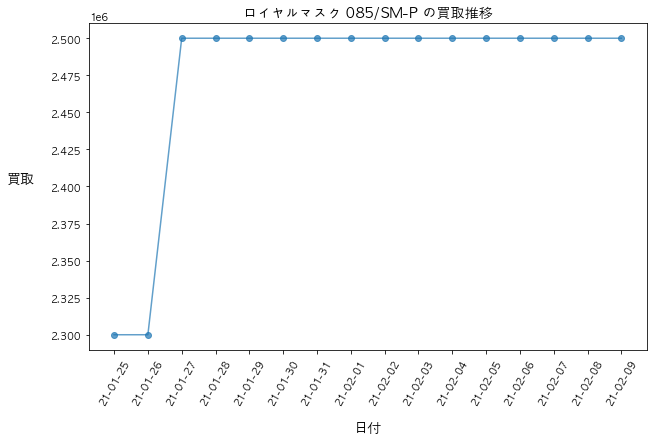

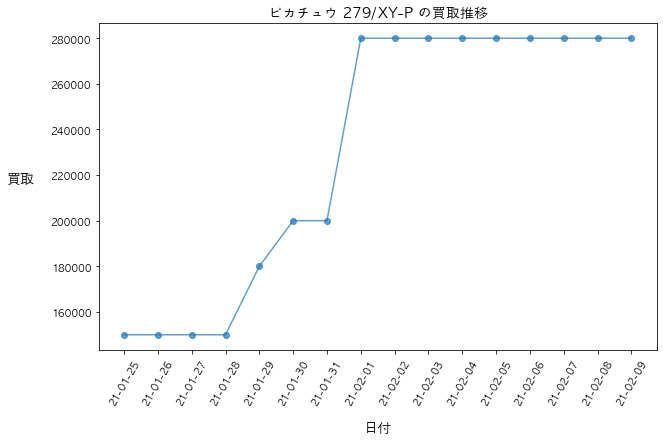

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


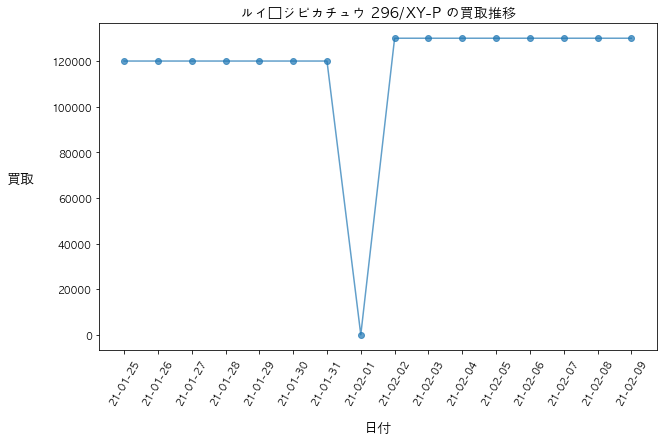

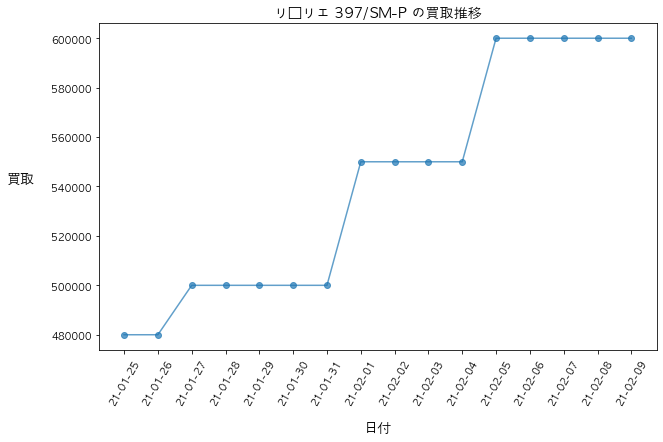

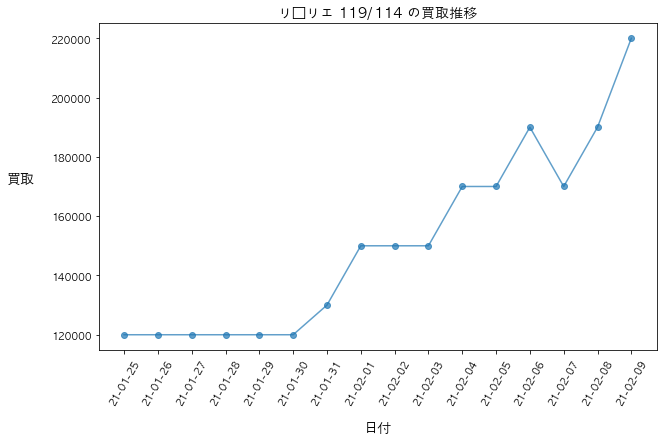

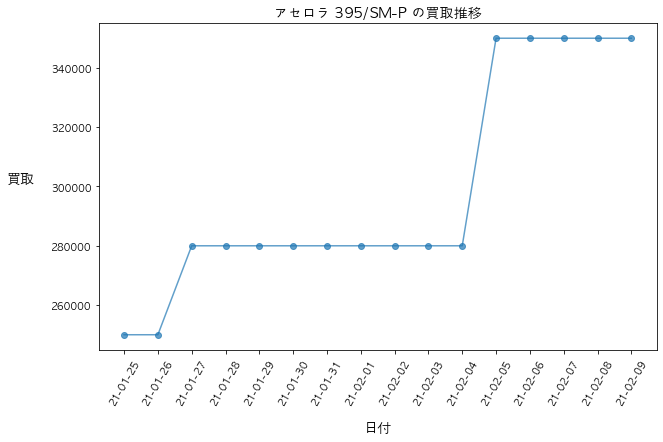

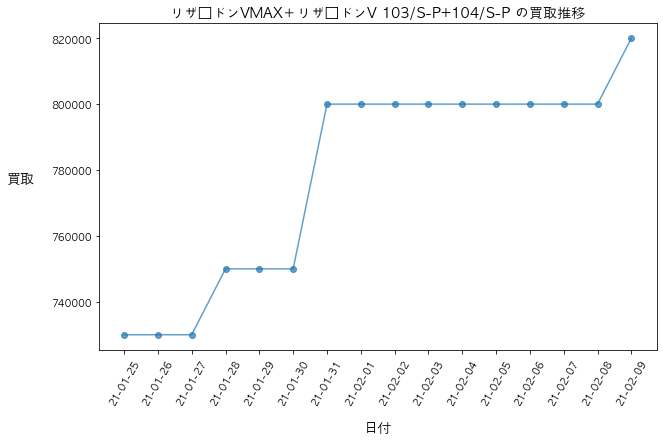

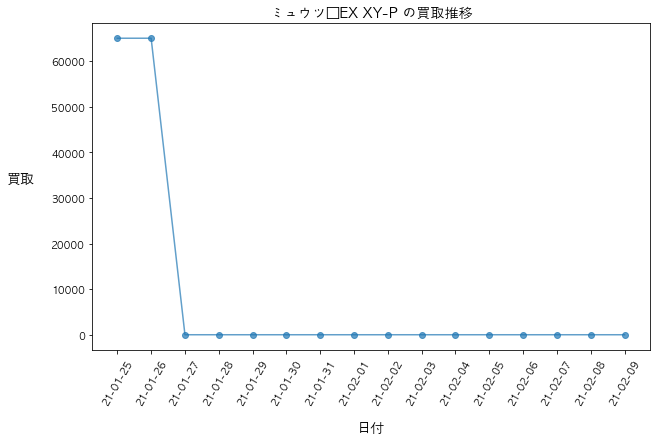

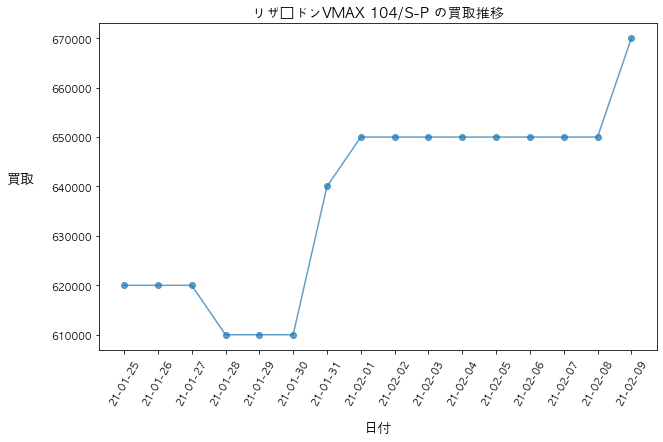

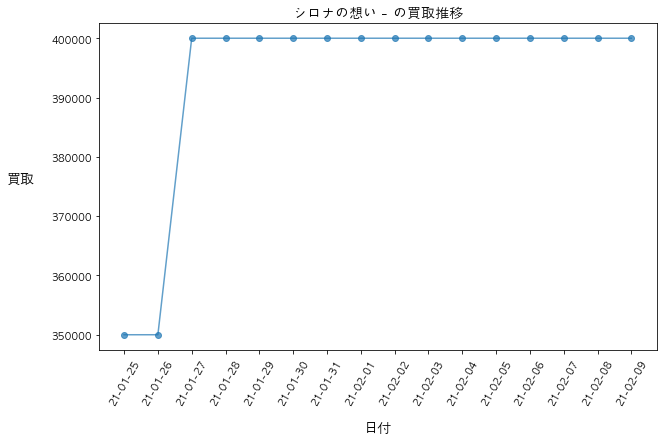

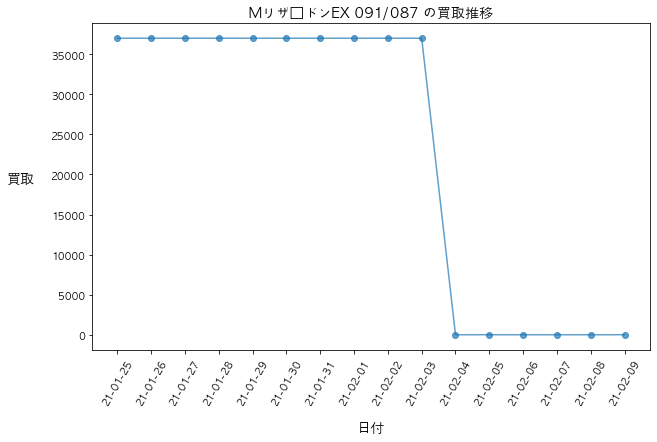

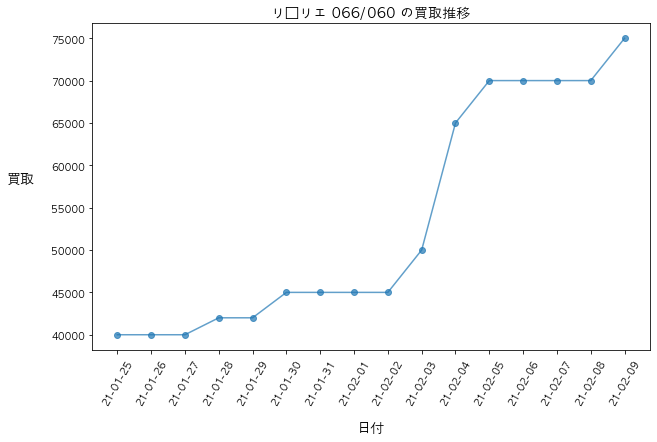

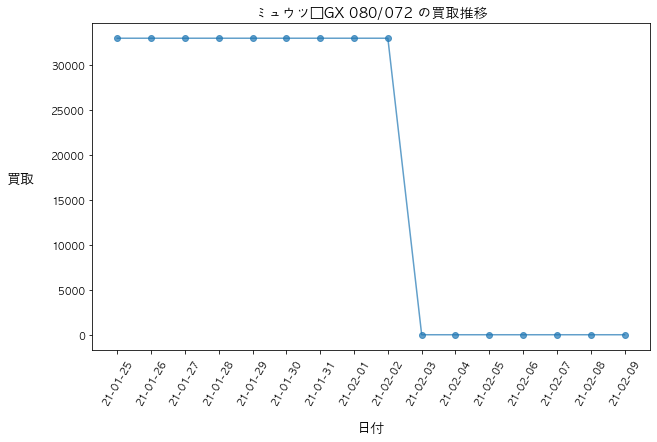

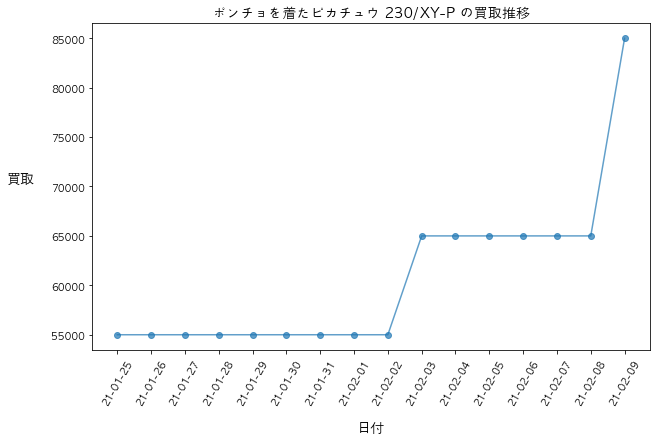

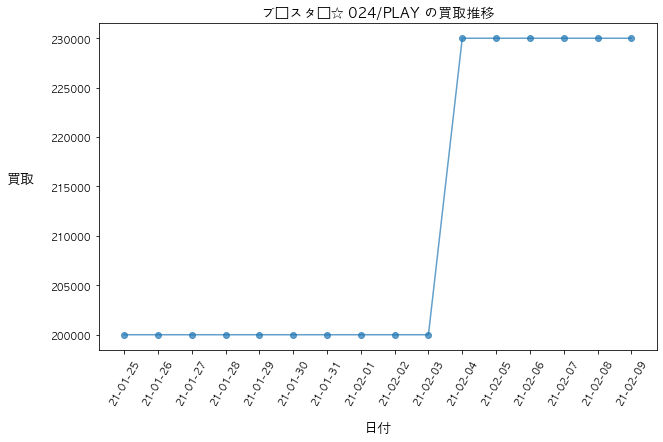

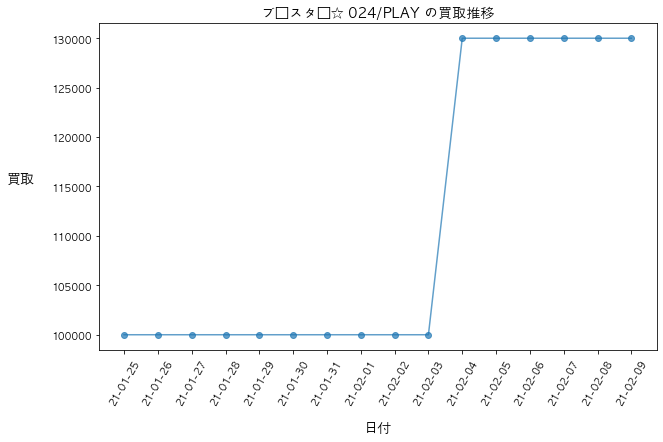

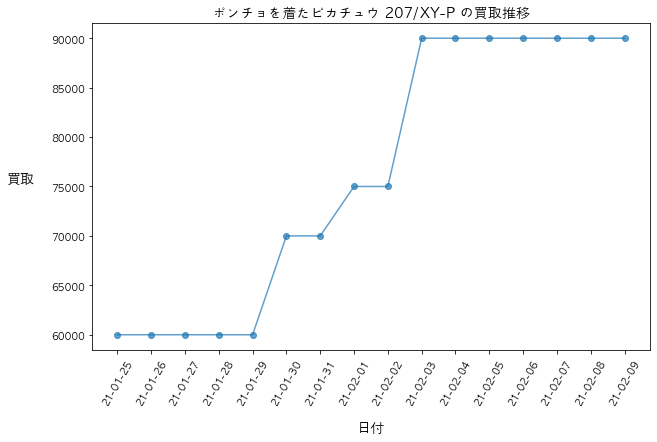

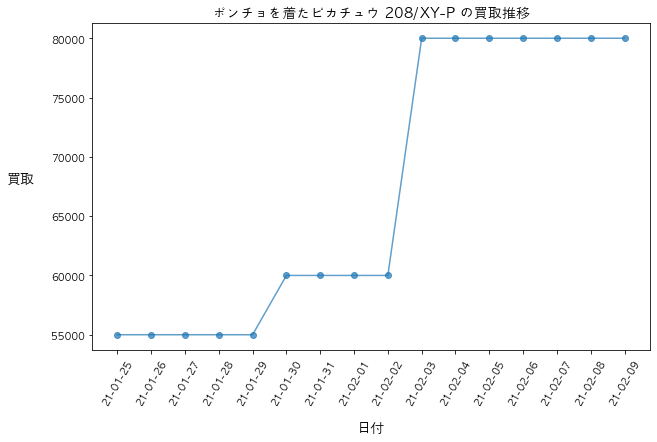

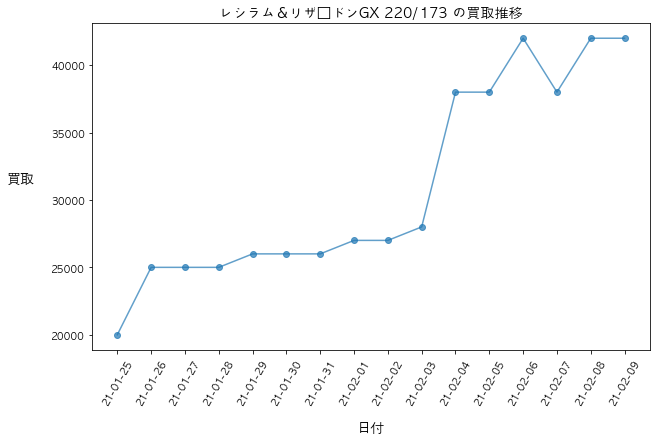

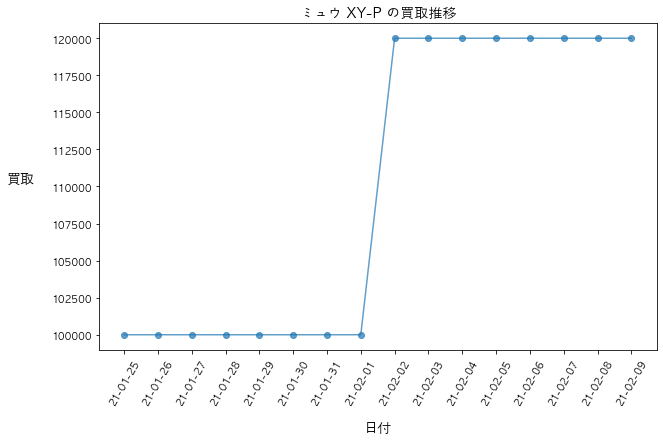

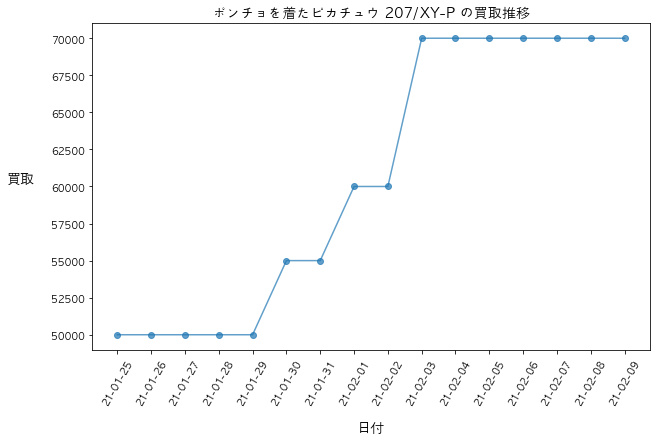

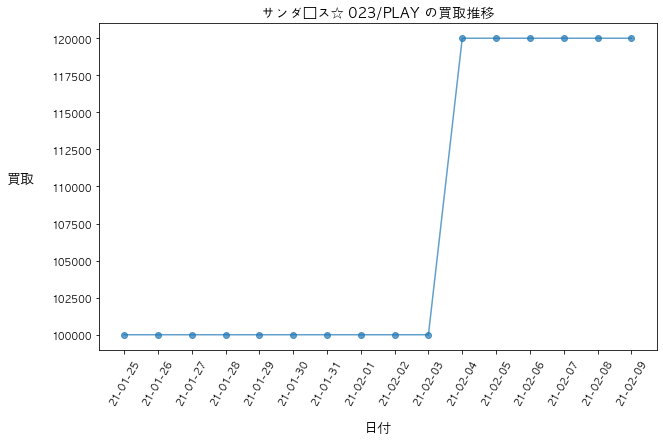

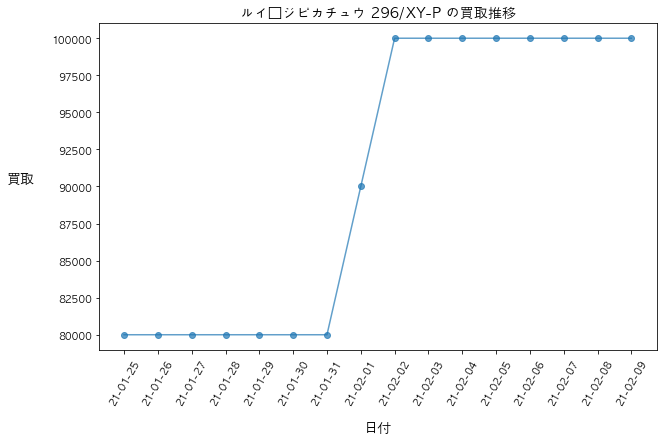

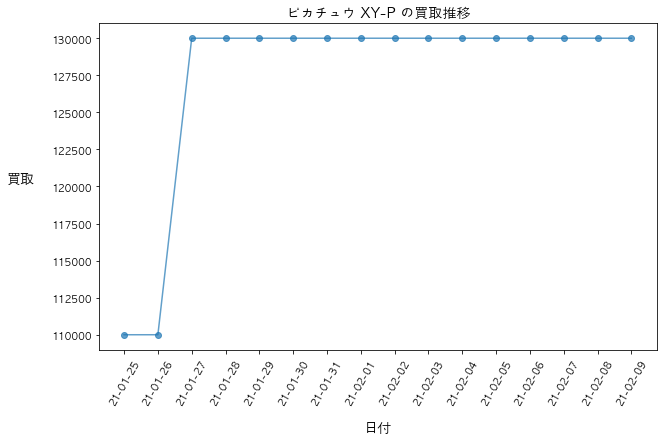

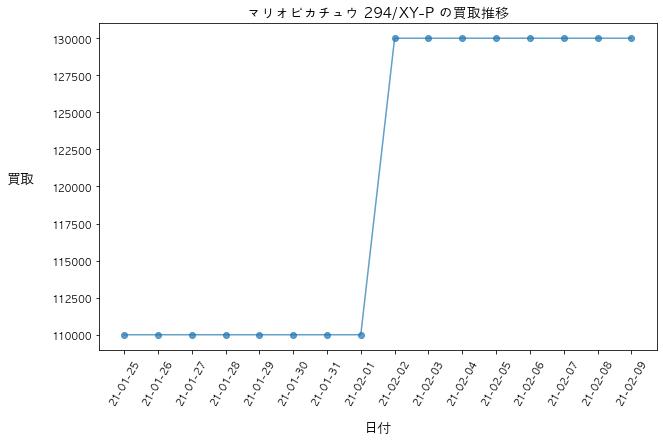

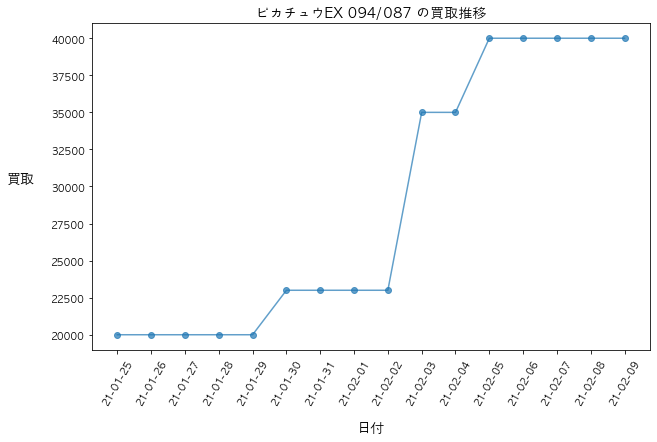

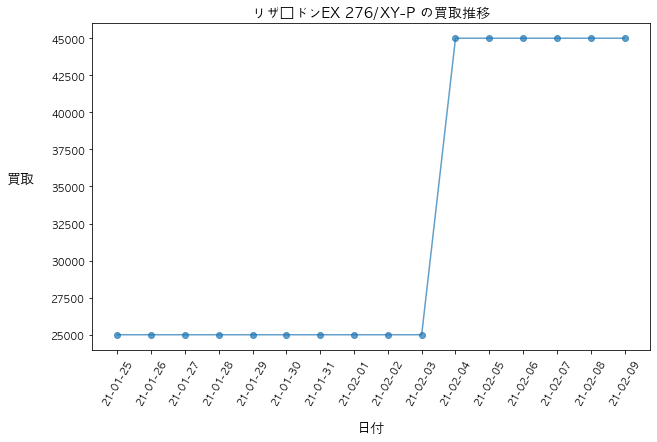

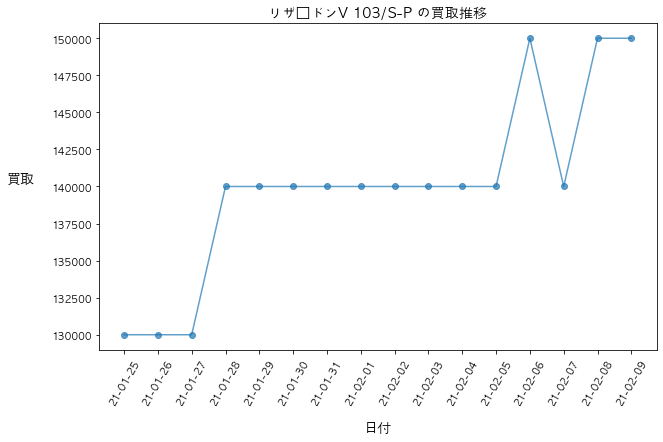

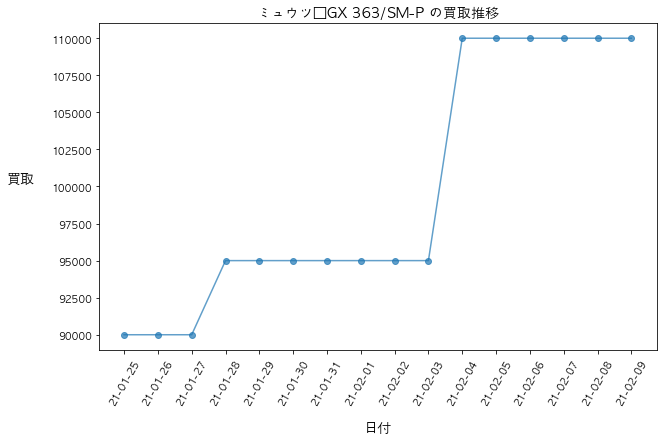

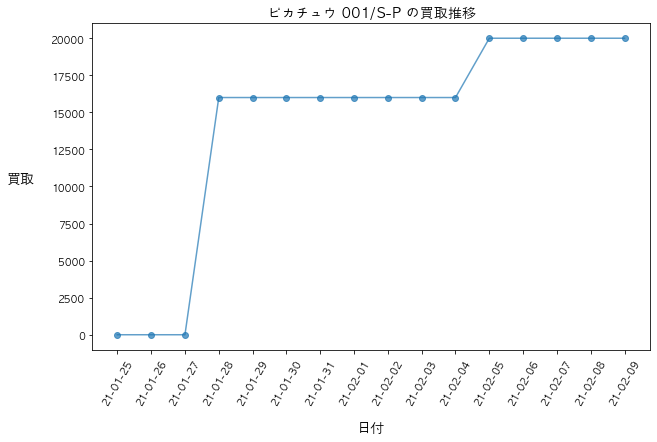

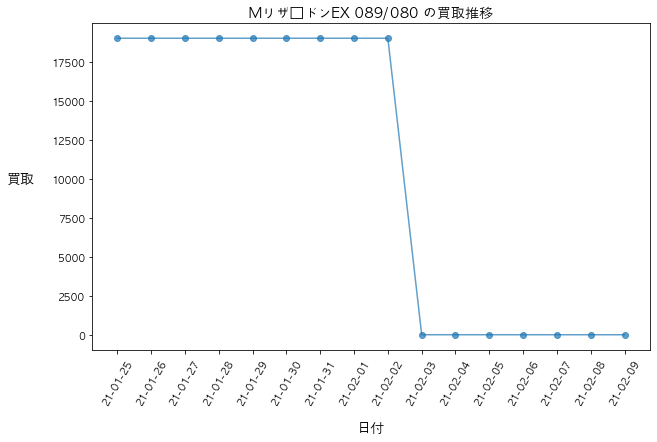

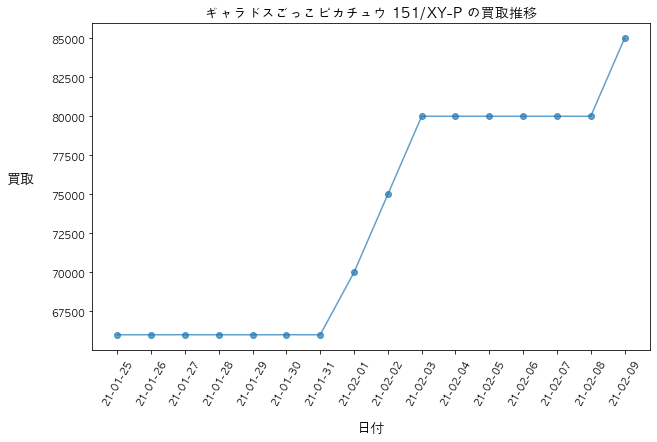

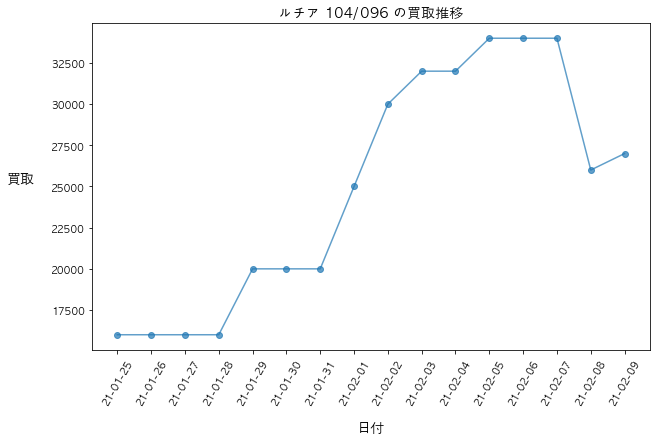

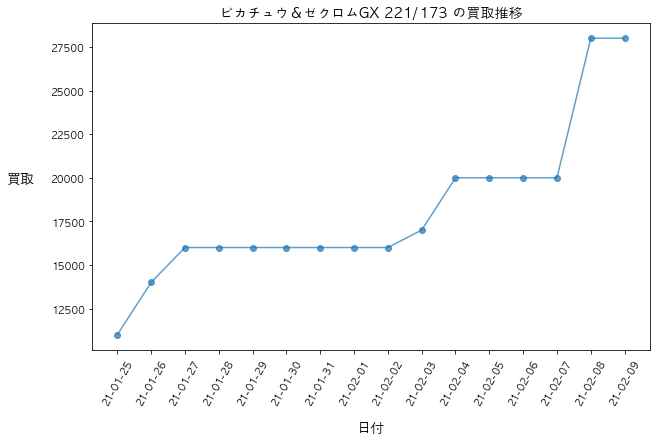

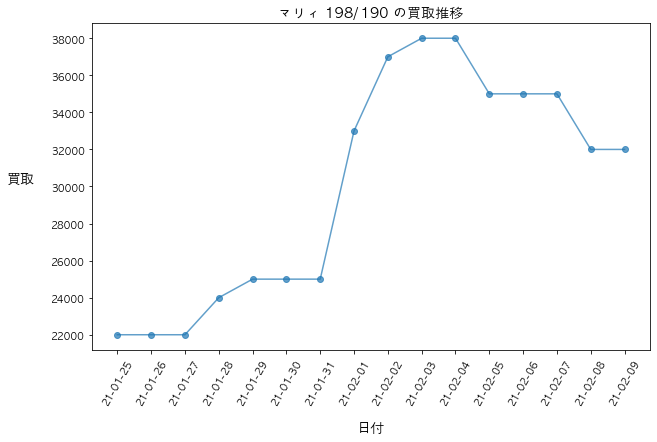

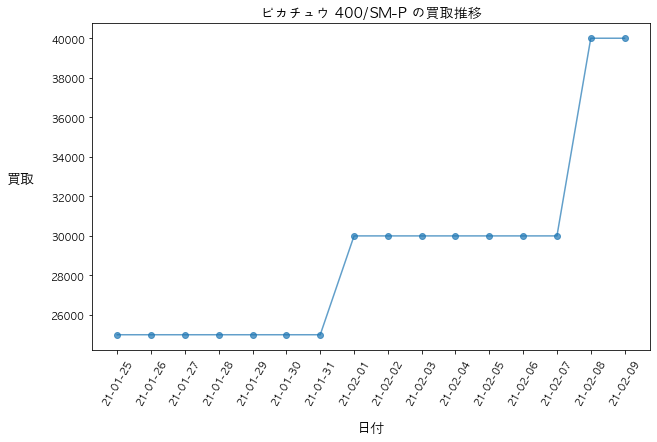

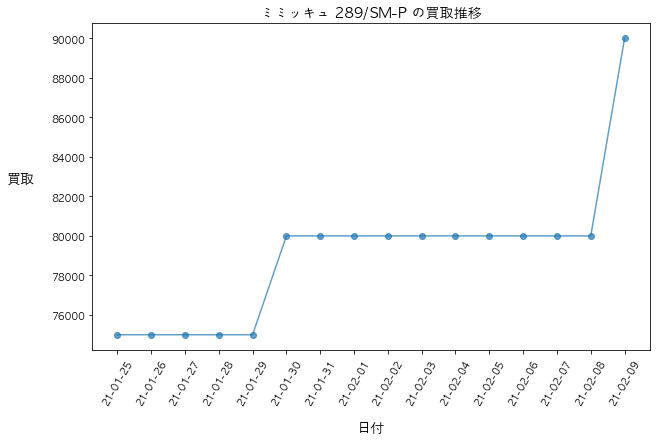

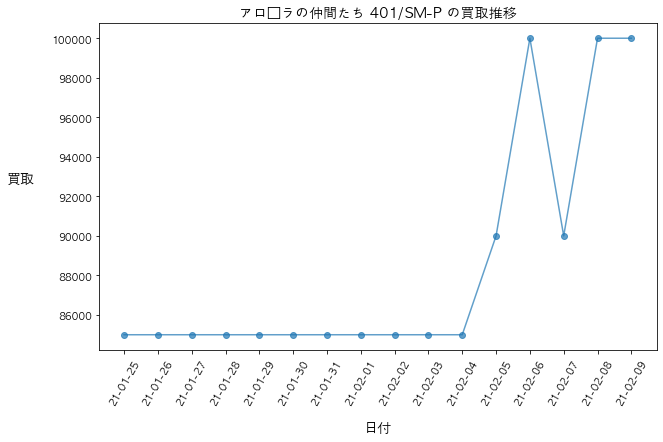

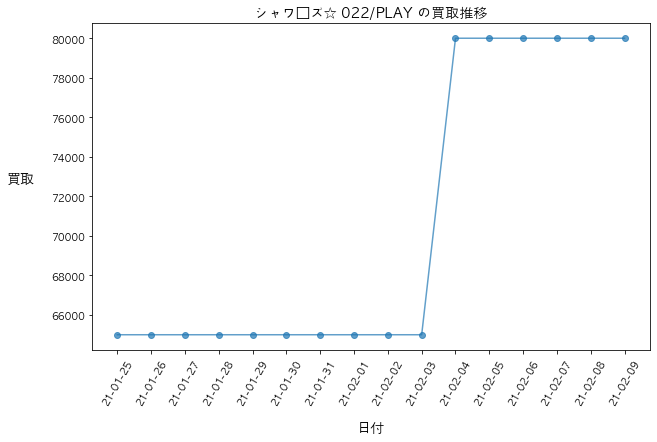

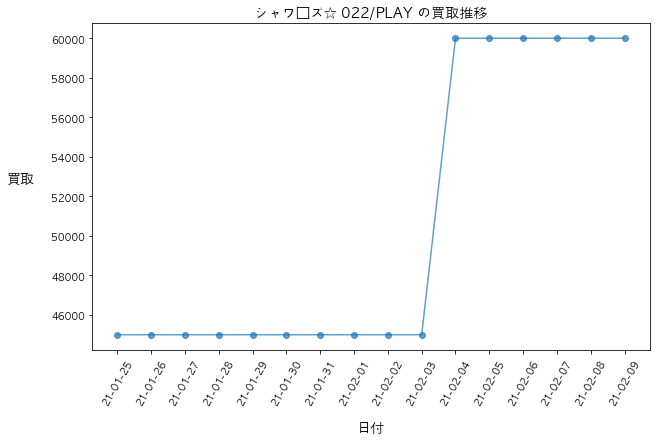

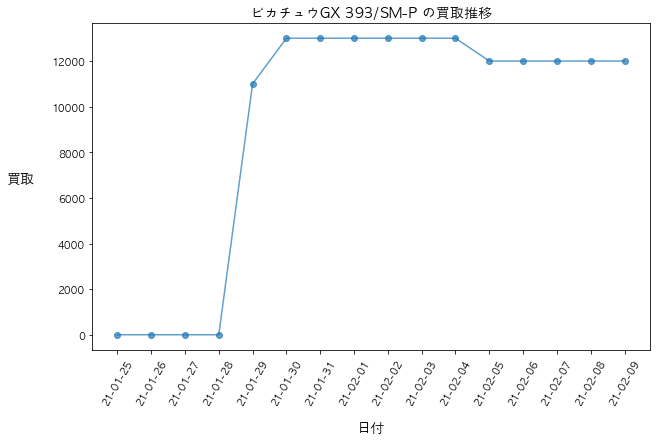

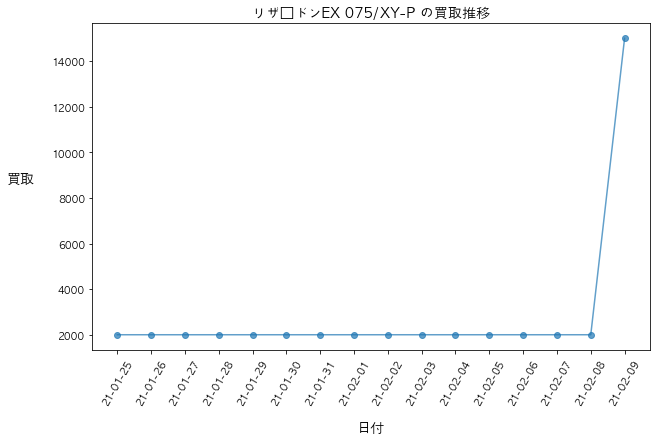

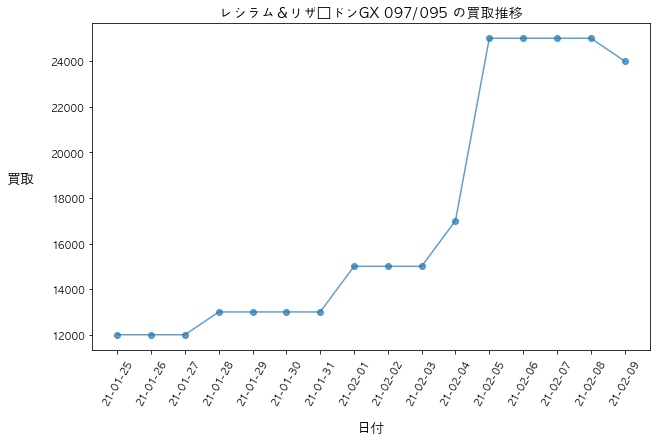

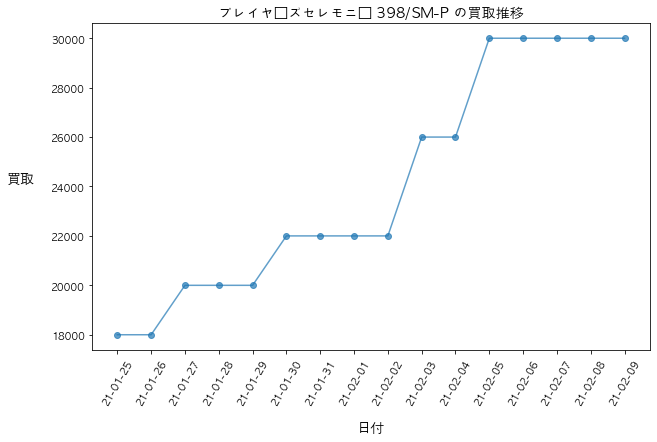

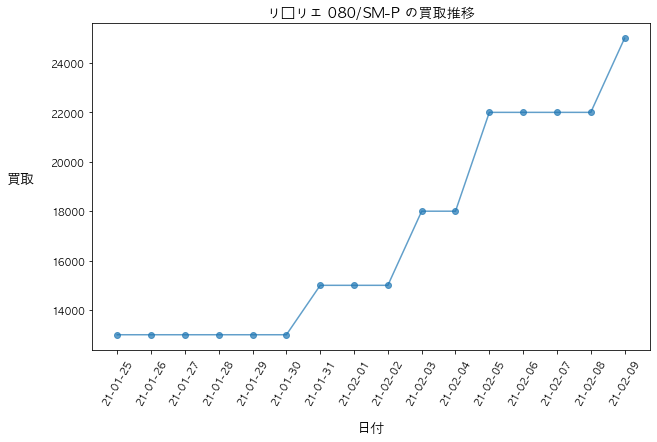

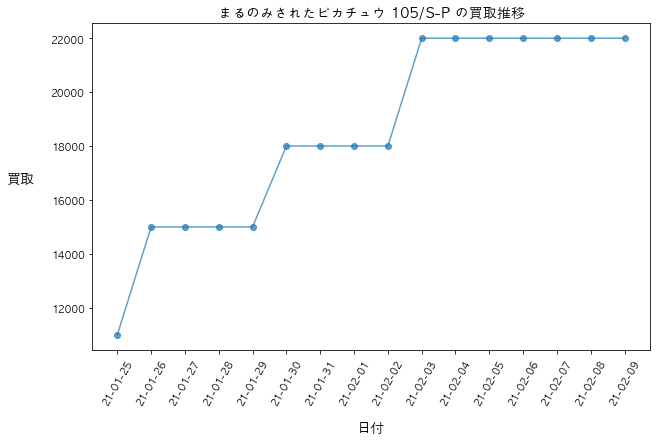

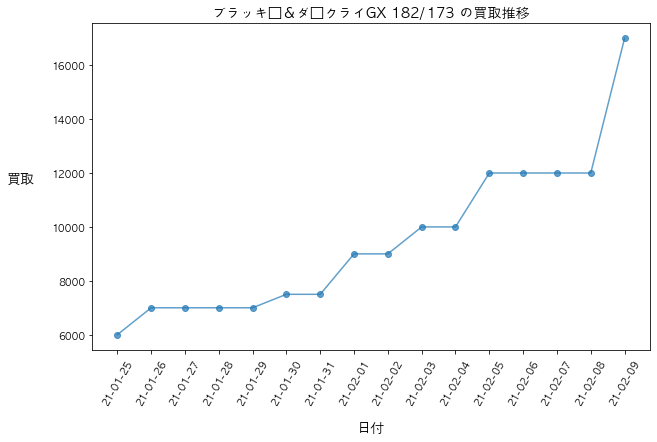

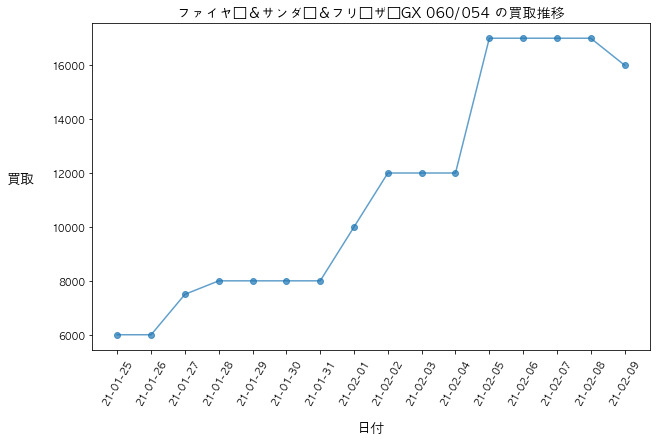

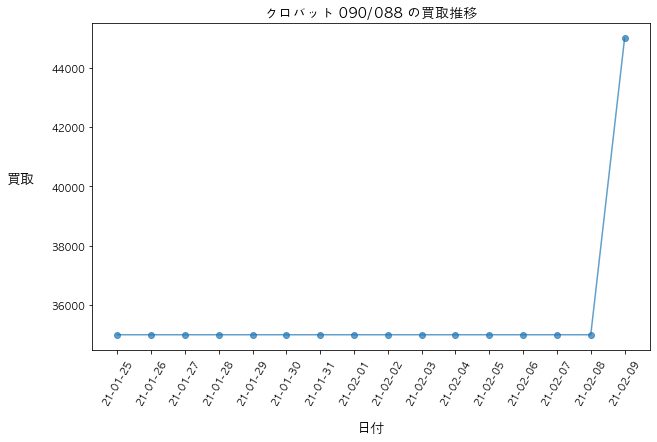

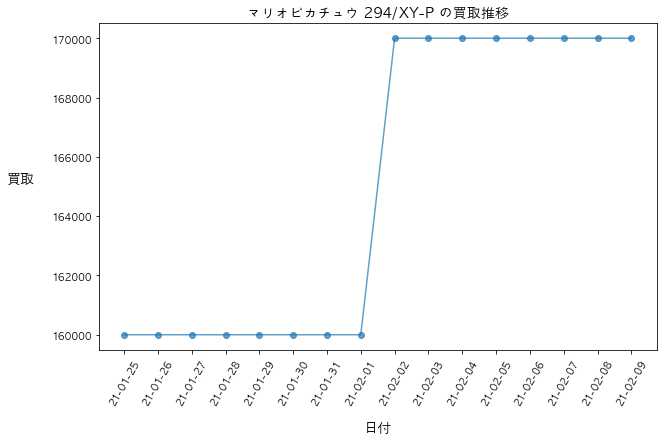

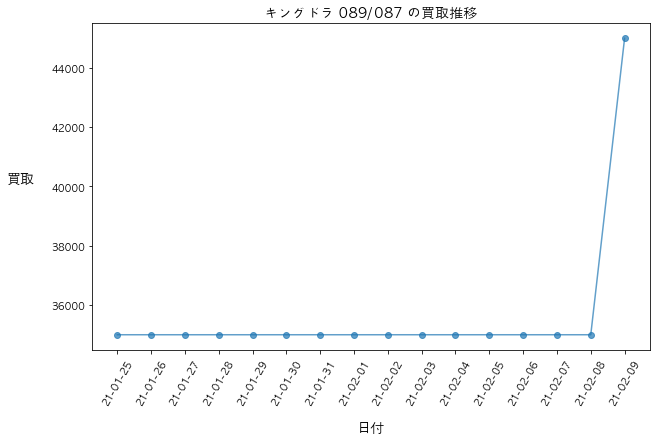

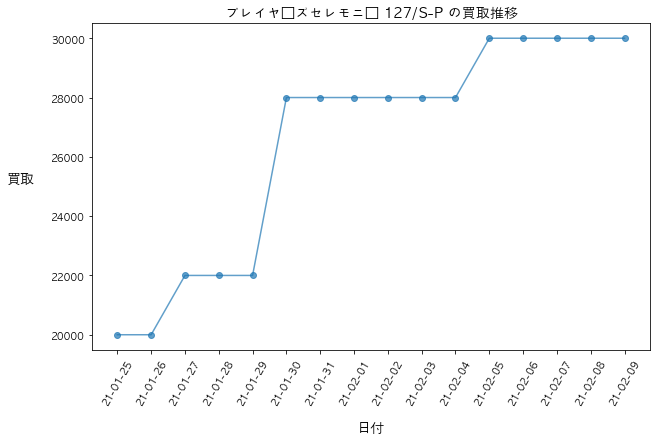

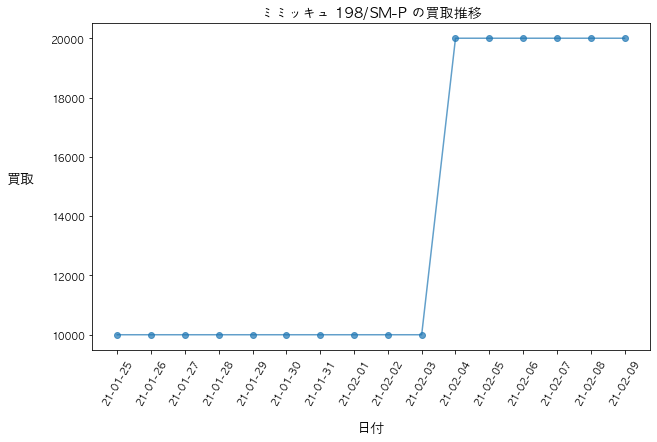

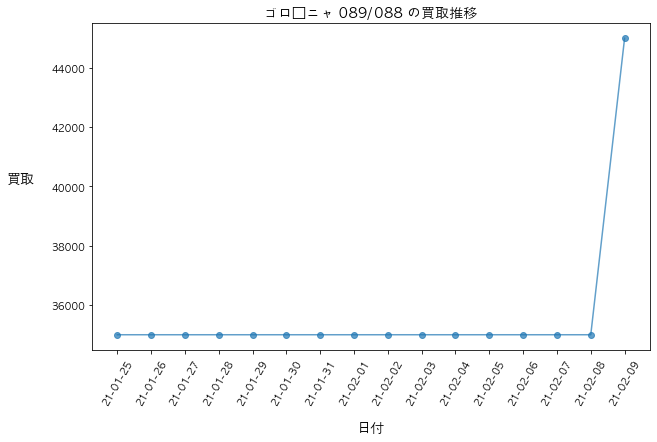

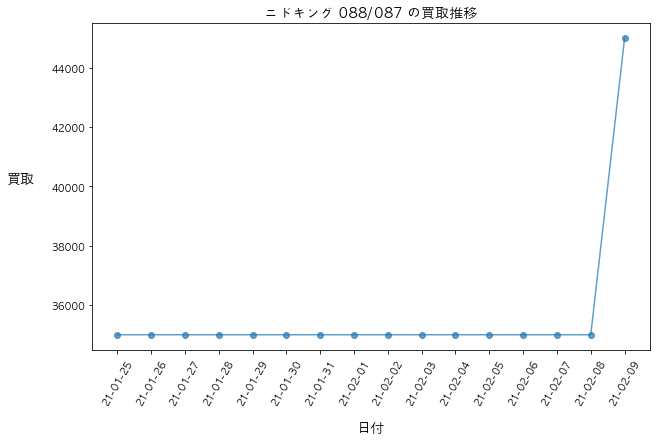

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22243 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22243 missing from current font.
  font.set_text(s, 0, flags=flags)


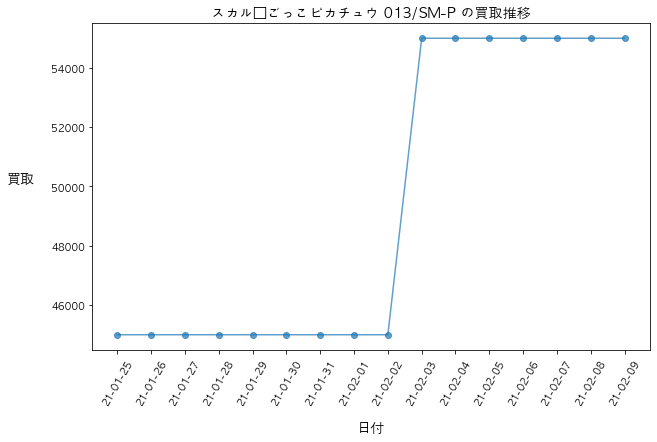

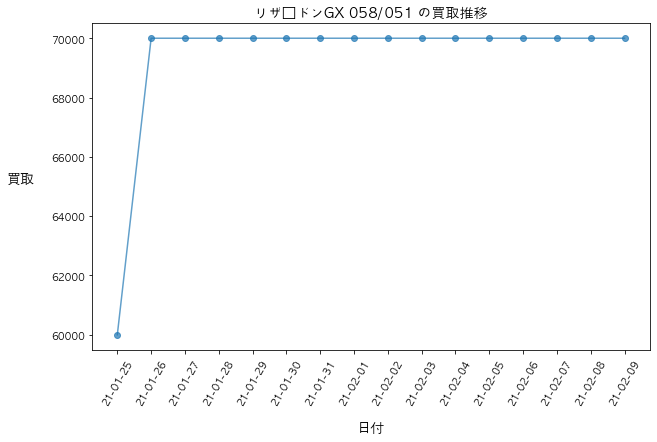

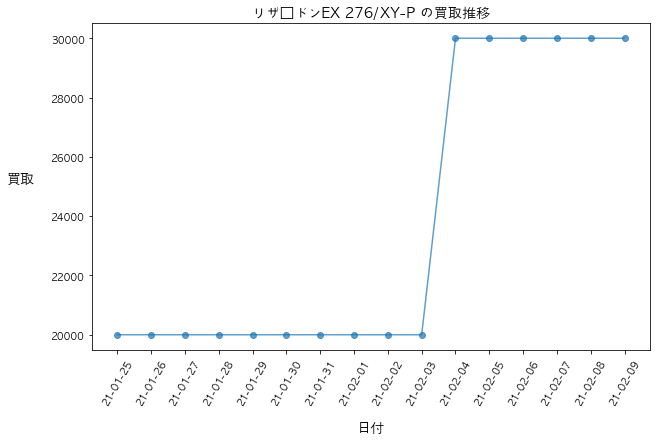

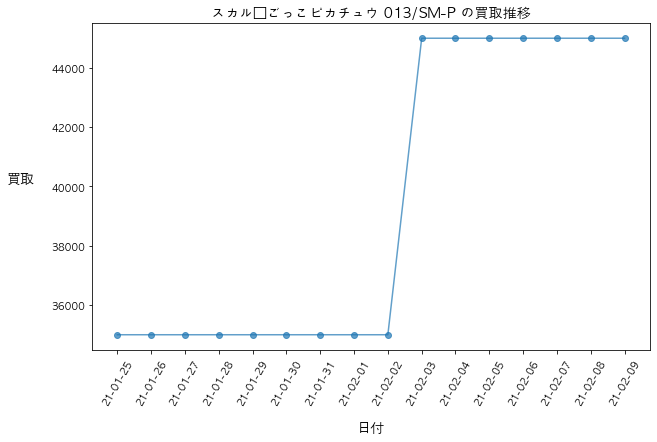

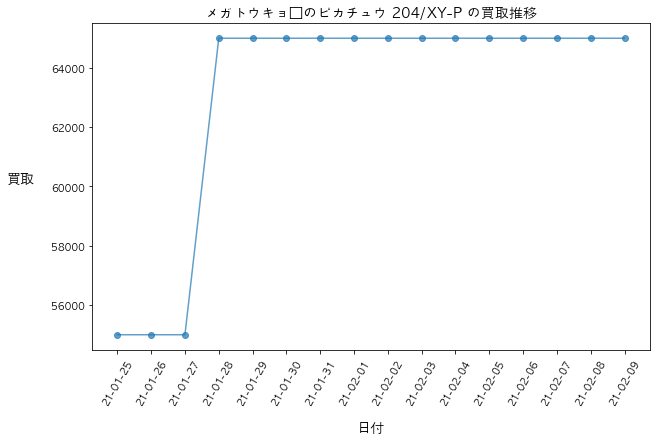

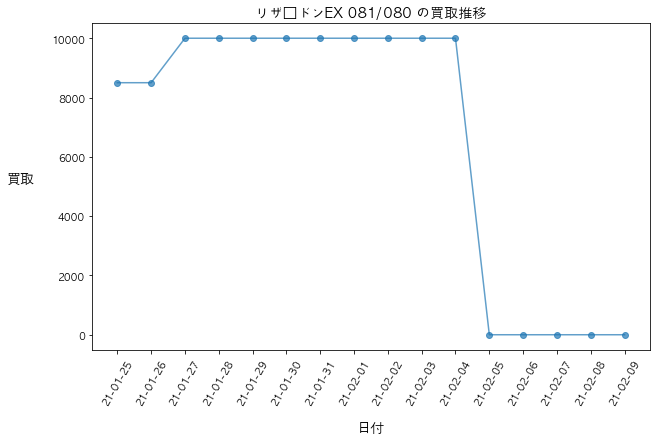

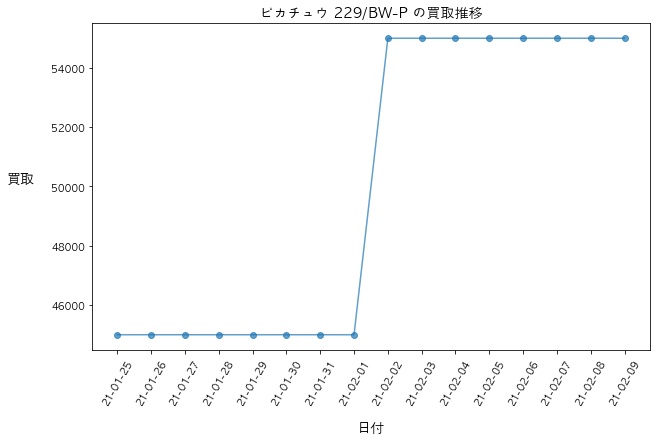

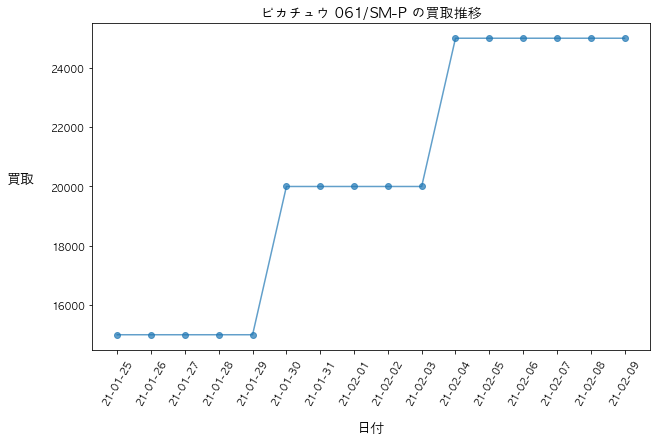

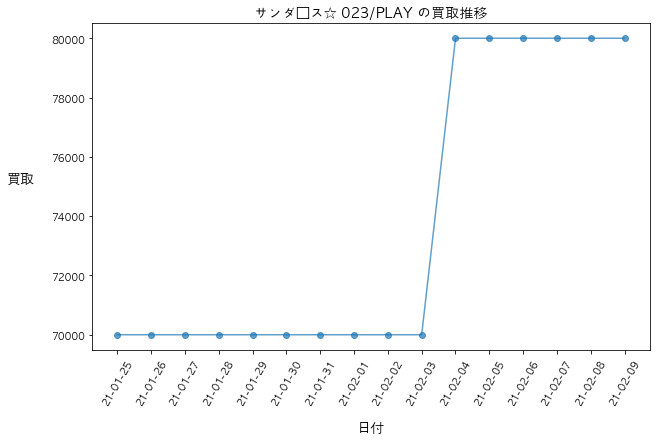

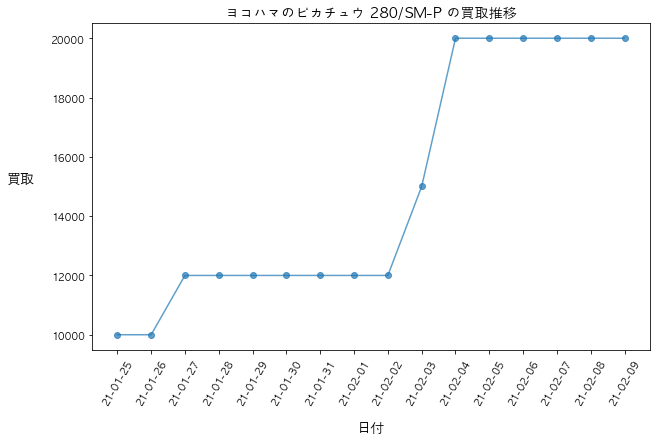

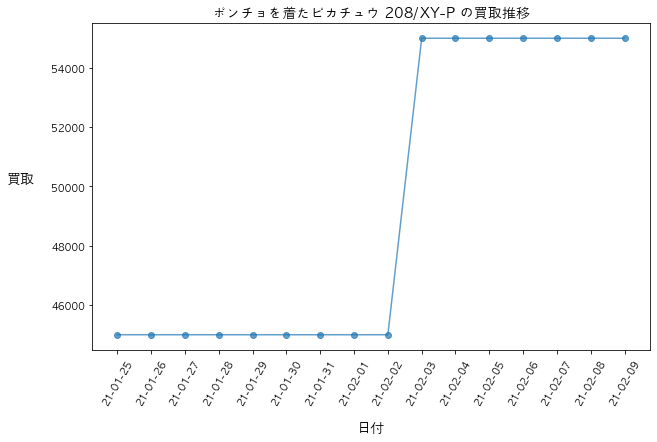

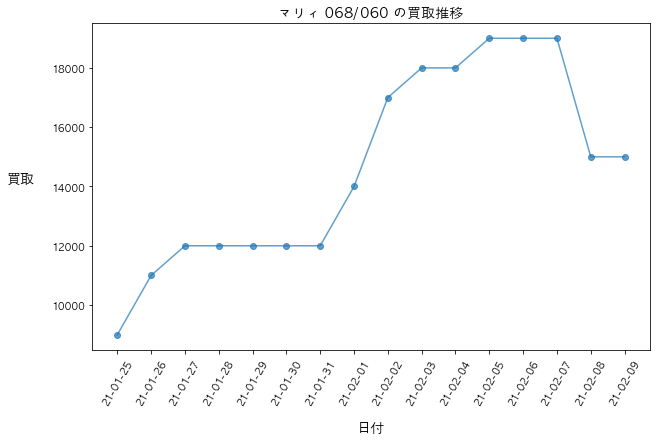

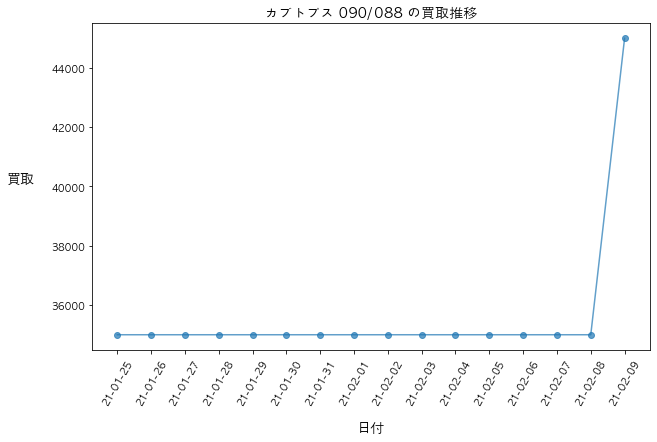

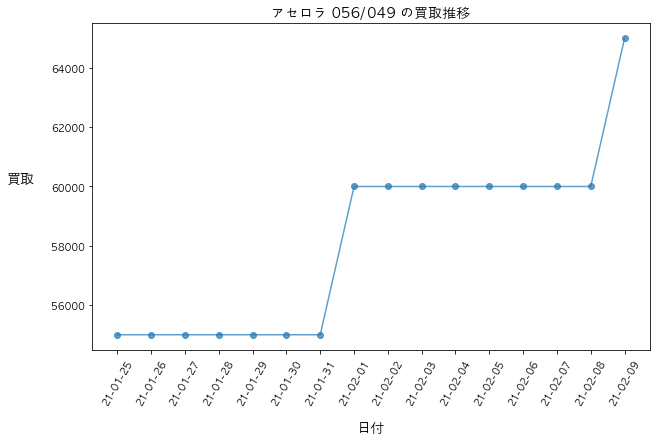

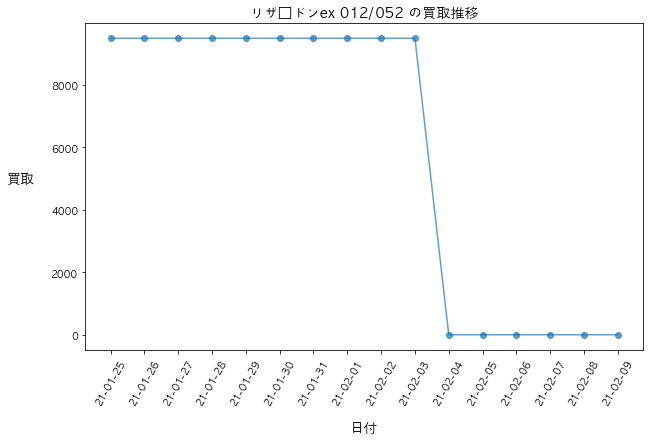

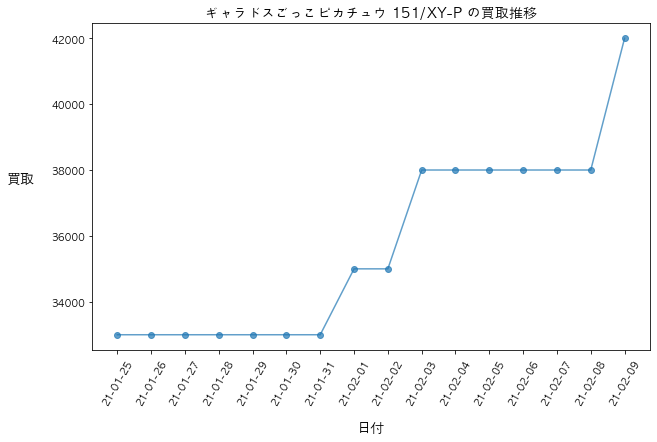

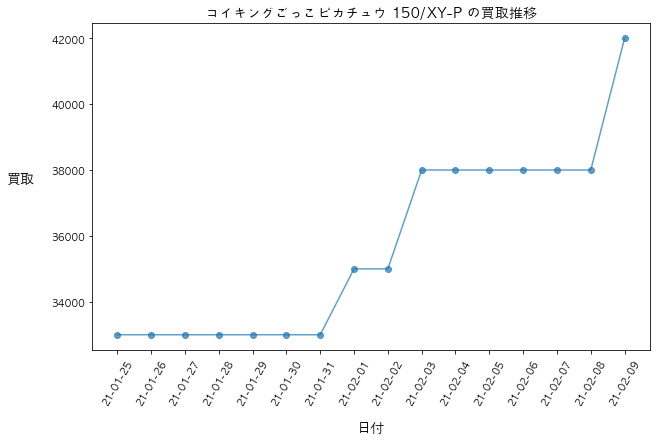

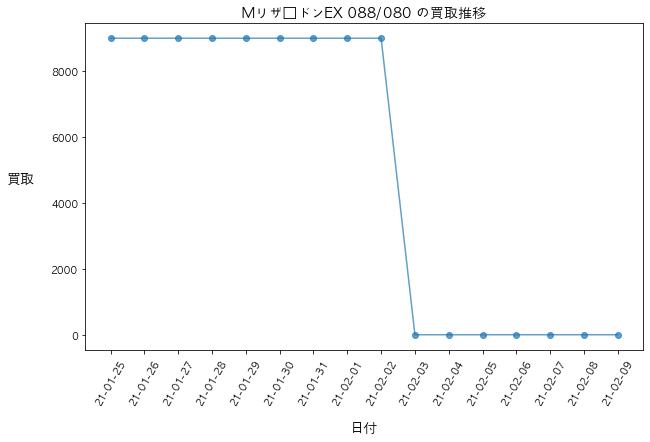

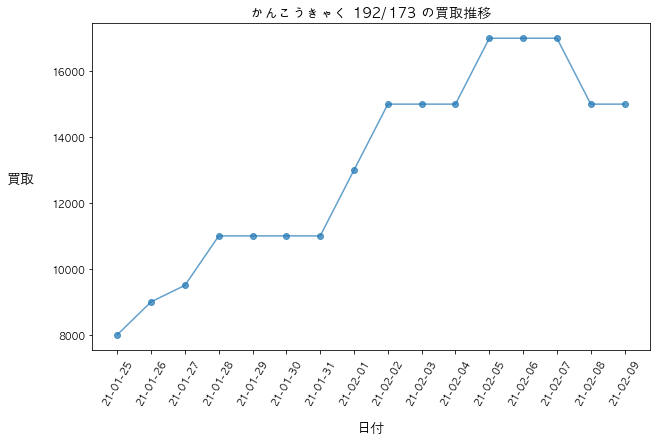

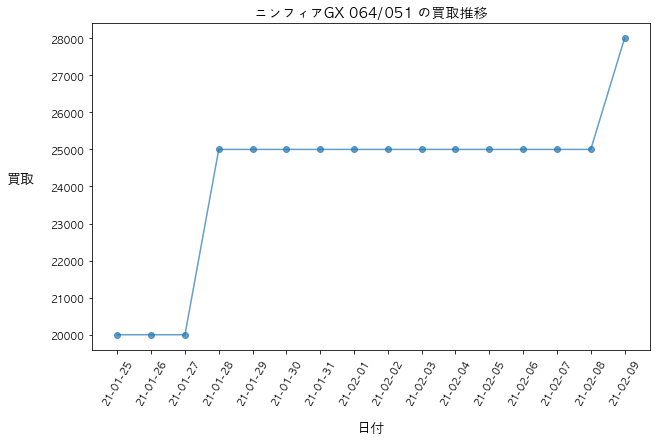

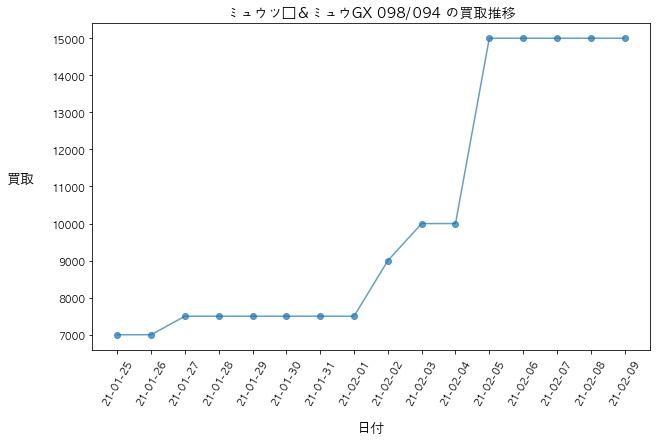

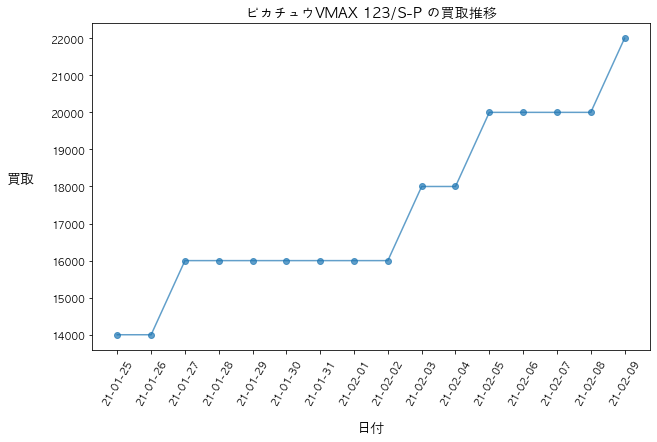

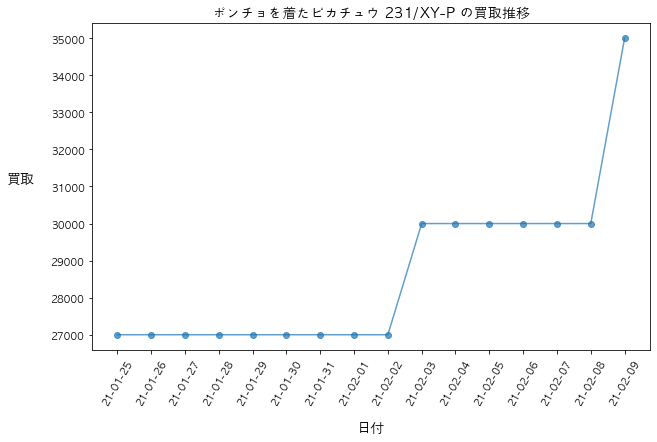

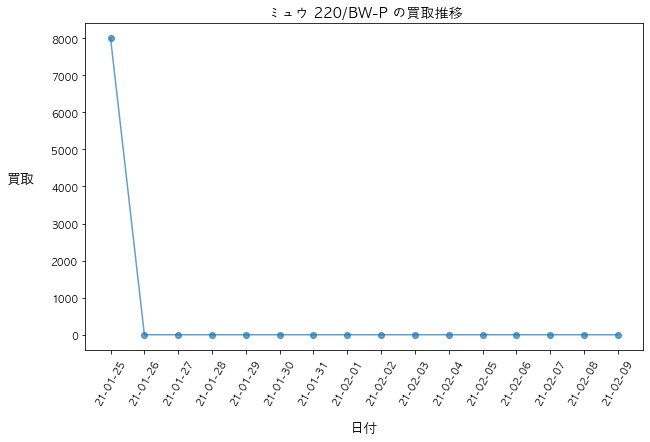

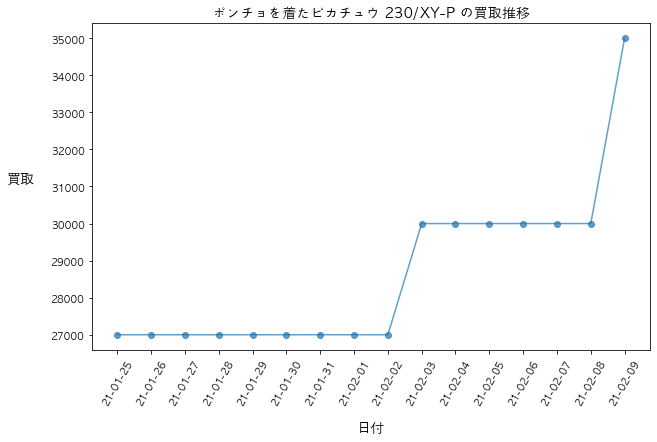

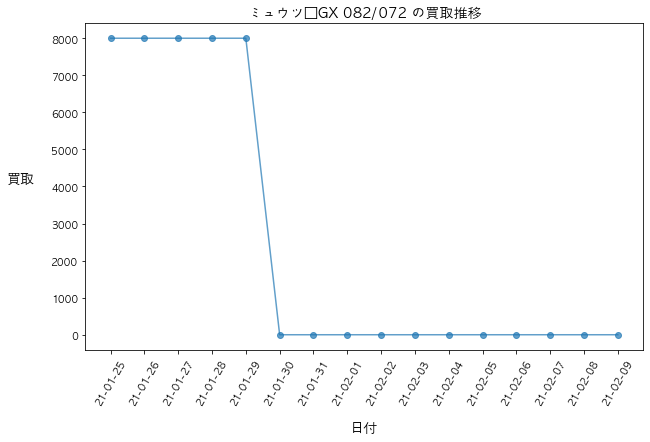

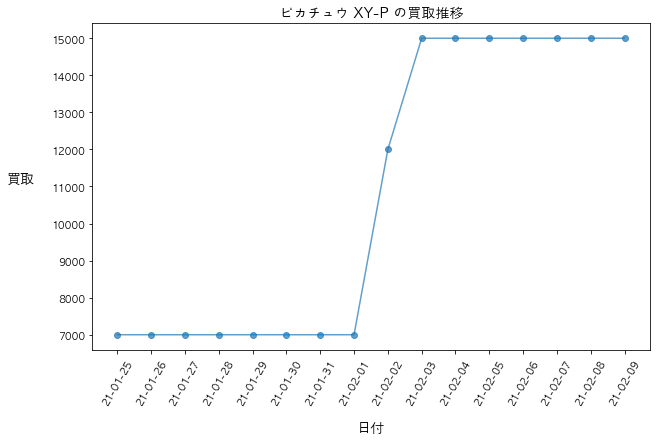

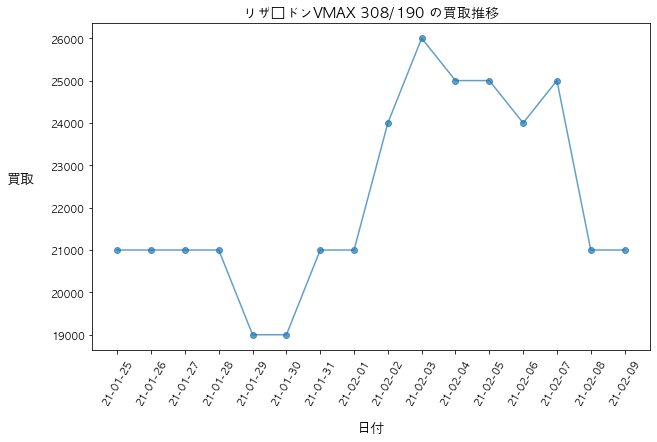

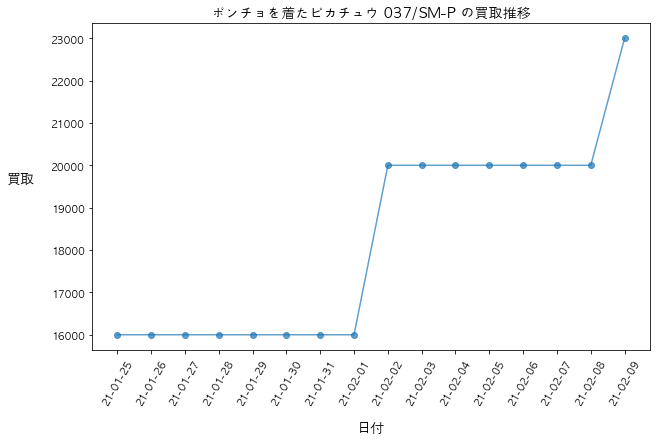

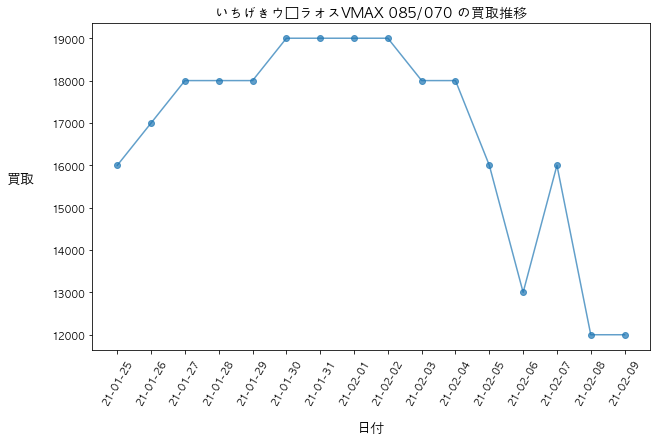

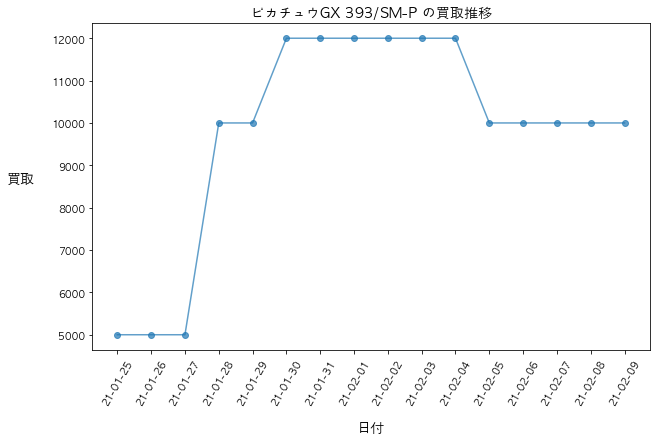

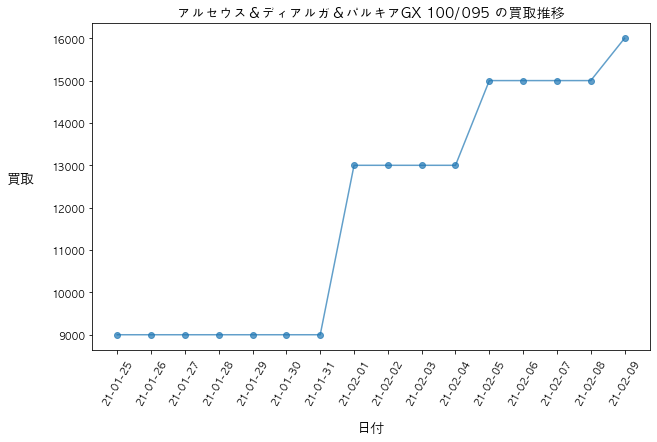

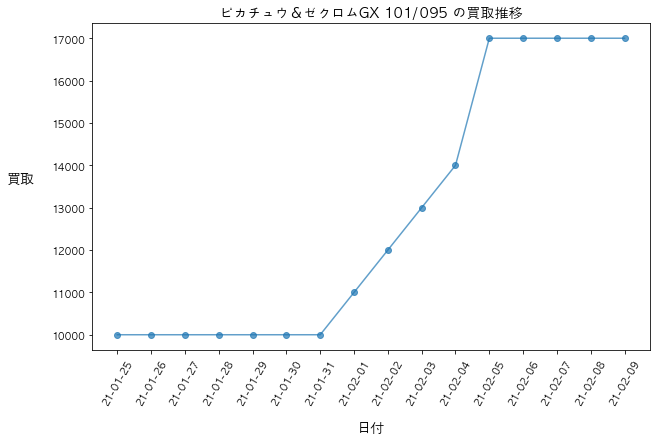

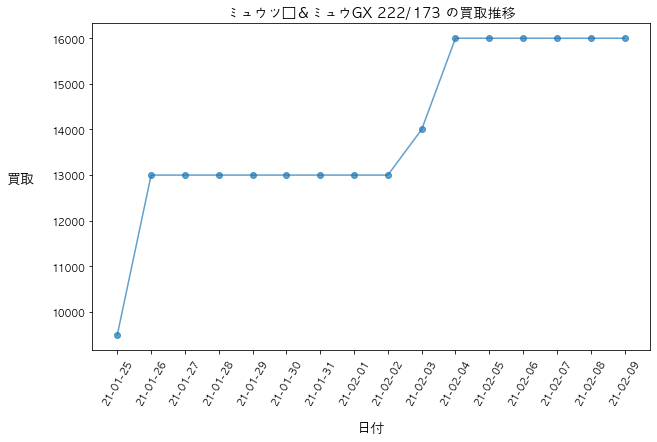

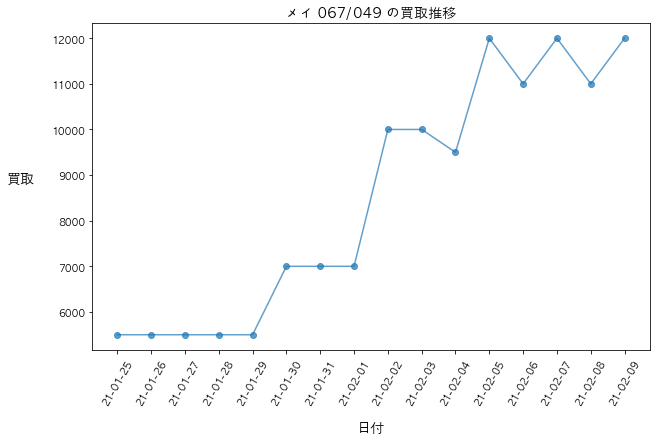

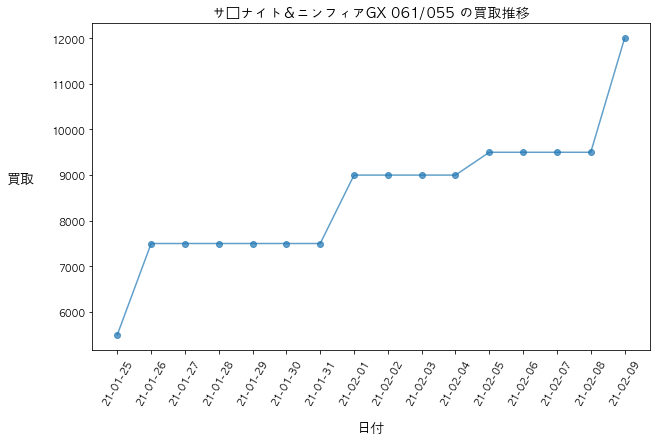

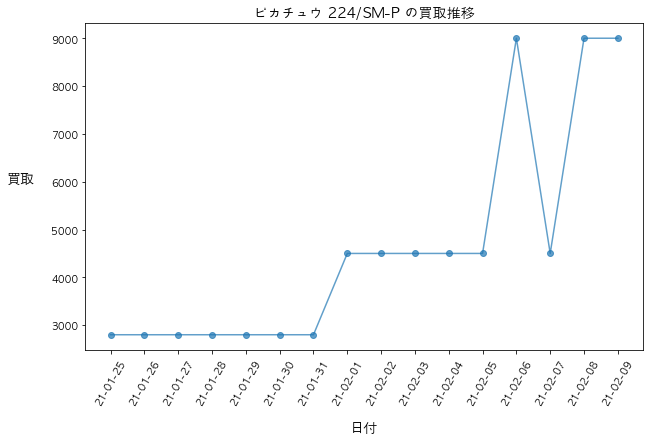

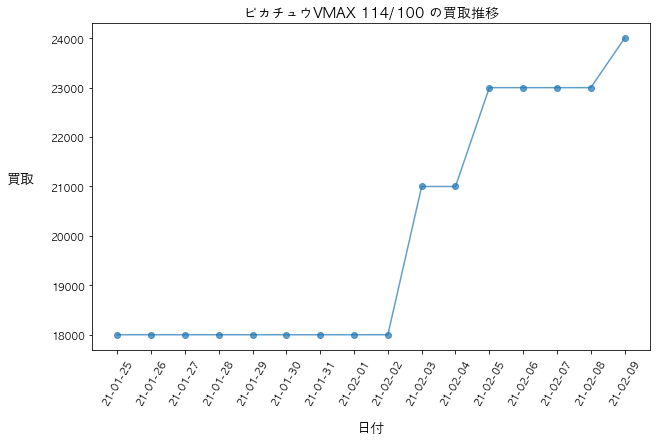

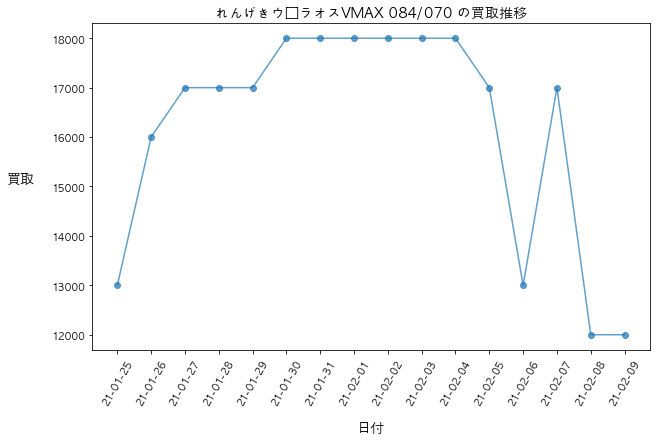

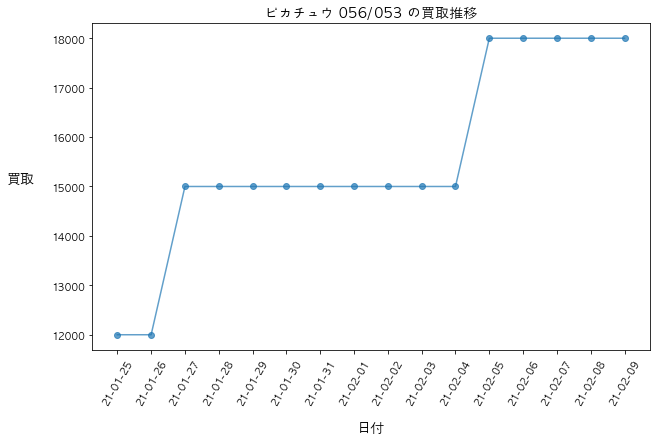

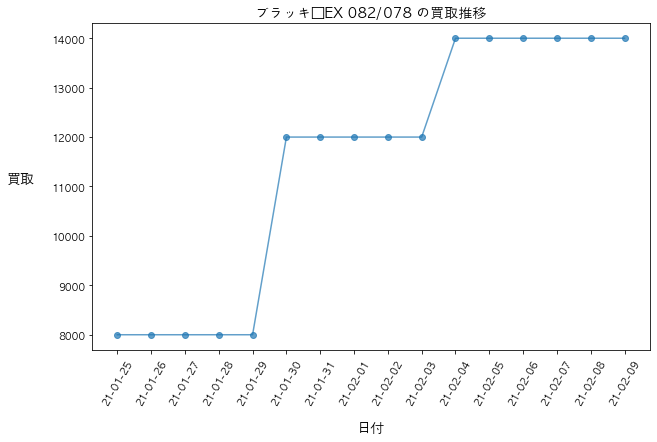

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0, flags=flags)


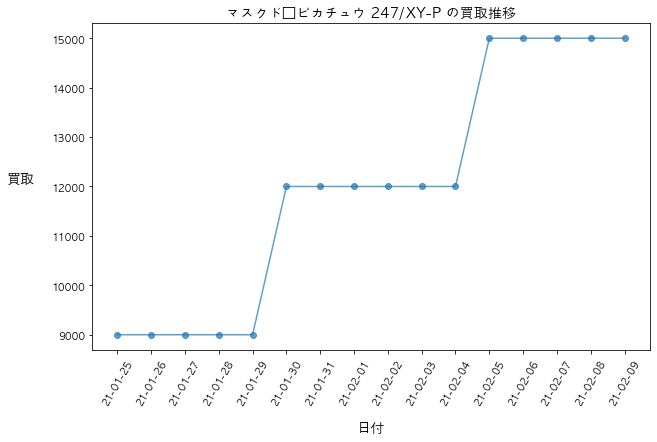

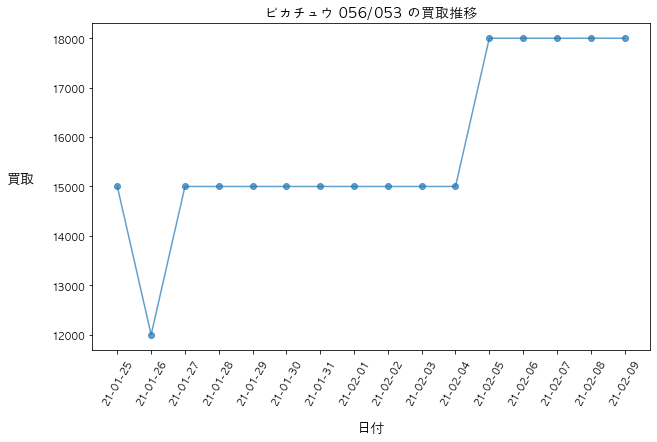

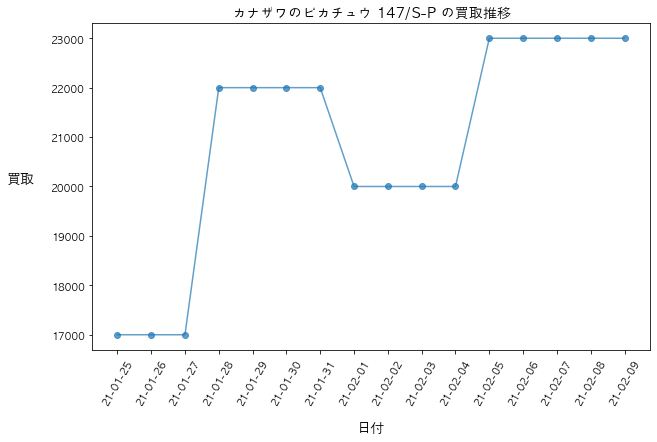

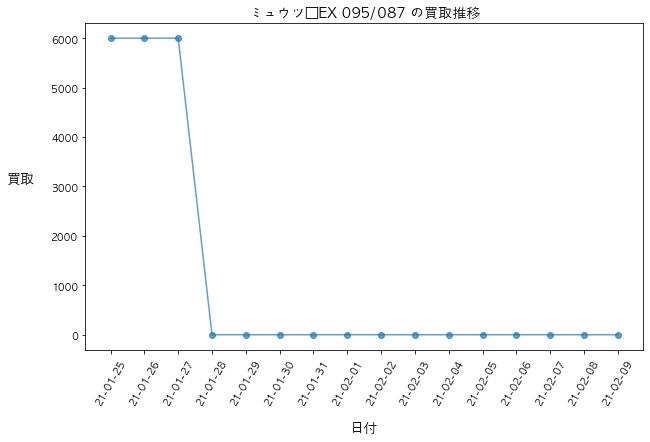

In [43]:
for i in range(100):
    data = df_plot[i:i+1].T
    graph_data = data[4:len(data)-1]
    plt.figure(figsize = (10,6))
    plt.plot(graph_data.iloc[::1,0],
             alpha = 0.7,
             marker = 'o')
    plt.xticks(rotation = 60)
    plt.xlabel('日付',fontsize = 14,labelpad = 15)
    plt.ylabel('買取',fontsize = 14,rotation = 0,labelpad= 30)
    plt.title(f'{data.iloc[0,0]} {data.iloc[3,0]} の買取推移',fontsize = 14)
    plt.show()

In [41]:
pd.set_option('display.max_columns',10)
df_plot['range/today'] = df_plot['range'] / df_plot[today]
df_plot

,カード名,仕様,R,型番,21-01-25,...,21-02-07,21-02-08,21-02-09,range,range/today
0,ロイヤルマスク,SR仕様,P,085/SM-P,2300000,...,2500000,2500000,2500000,200000,0.080000
1,ピカチュウ,-,P,279/XY-P,150000,...,280000,280000,280000,130000,0.464286
2,ルイージピカチュウ,未開封,P,296/XY-P,120000,...,130000,130000,130000,130000,1.000000
3,リーリエ,SR仕様,P,397/SM-P,480000,...,600000,600000,600000,120000,0.200000
4,リーリエ,-,SR,119/114,120000,...,170000,190000,220000,100000,0.454545
...,...,...,...,...,...,...,...,...,...,...,...
3721,ガオガエンGX,-,HR,061/052,100,...,100,100,100,0,0.000000
3722,バクガメスGX,-,HR,056/050,200,...,200,200,200,0,0.000000
3723,バクガメスGX,-,SR,051/050,200,...,200,200,200,0,0.000000
3724,エンテイGX,-,HR,078/072,2000,...,2000,2000,2000,0,0.000000


In [40]:
pd.set_option('display.max_rows',30)
df_plot[df_plot['カード名'].str.contains('リザードン')].sort_values(by = 'カード名')

,カード名,仕様,R,型番,21-01-25,...,21-02-07,21-02-08,21-02-09,range,range/today
10,MリザードンEX,Y,SR,091/087,37000,...,0,0,0,37000,inf
247,MリザードンEX,Y,-,002/021,1600,...,0,0,0,1600,inf
242,MリザードンEX,Y,RR,013/087,1800,...,0,0,0,1800,inf
30,MリザードンEX,X,UR,089/080,19000,...,0,0,0,19000,inf
154,MリザードンEX,X,-,011/072,4000,...,0,0,0,4000,inf
...,...,...,...,...,...,...,...,...,...,...,...
927,レシラム＆リザードンGX,-,RR,016/173,150,...,200,200,200,50,0.250000
42,レシラム＆リザードンGX,SA,SR,097/095,12000,...,25000,25000,24000,13000,0.541667
18,レシラム＆リザードンGX,-,UR,220/173,20000,...,38000,42000,42000,22000,0.523810
552,レシラム＆リザードンGX,-,SR,096/095,2500,...,2800,2800,2800,300,0.107143
